In [1]:
import numpy as np
import pandas as pd


In [2]:
df = pd.read_csv('data/2022-01-05.csv', index_col=0)
df.head(5)


,price,bd_num,ba_num,sqft,address,zestimate,Building,Calendar,Heating,Snowflake,Parking,Lot,PriceSquareFeet,url,zipcode
0,"$279,900",3,1,"1,324","3072 Beechwood Blvd,Pittsburgh, PA 15217","$275,900",Single family residence,Built in 1940,"Natural gas, baseboard","Wall unit(s), window a/c",Open parking,"3,049 sqft",$211 price/sqft,https://www.zillow.com/homedetails/3072-Beechw...,15106
1,"$258,900",4,3,"2,854","304 Washington Ave,New Galilee, PA 16141",Contact Agent,Single family residence,Built in 1957,"Natural gas, forced air",Central air,2 Attached garage spaces,0.42 Acres,$91 price/sqft,https://www.zillow.com/homedetails/304-Washing...,15106
2,"$167,000",5,2,"3,698","1000 Ridge Ave,New Cumberland, WV 26047","$160,800",Single family residence,Built in 1875,"Forced air, fireplace(s), gas",None,3 Garage spaces,0.51 Acres,$45 price/sqft,https://www.zillow.com/homedetails/1000-Ridge-...,15106
3,"$350,000",3,3,"2,180","165 Jamison Ln,Monroeville, PA 15146","$350,100",Single family residence,Built in 1965,"Electric, radiant","Central air, electric",3 Attached garage spaces,0.25 Acres,$161 price/sqft,https://www.zillow.com/homedetails/165-Jamison...,15106
4,"$219,900",3,3,"2,994","35 Northgait Dr,Slippery Rock, PA 16057",None,Single family residence,Built in 1985,No data,No data,2 Attached garage spaces,1.57 Acres,$73 price/sqft,https://www.zillow.com/homedetails/35-Northgai...,15106


[Feature Engineering for Categorical Attributes](https://dotdata.com/blog/feature-engineering-for-categorical-attributes/)

[One-Hot Encoding a Feature on a Pandas Dataframe: Examples](https://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example)

### Category column process:

- Building : One-hot
- Heating : One-hot with combination
- Snowflake : One-hot with combination
- Parking: label encoding
- Zipcode: One-hot

### Insignificant features:

- address


## Column classify


In [3]:
# price, bd_num, ba_num, sqft, zestimate, Calendar, Lot, PriceSquareFeet
num_cols = ['price', 'bd_num', 'ba_num', 'sqft', 'Calendar']
one_hot_cols = ['Building', 'zipcode']
one_hot_unstruc_cols = ['Heating', 'Snowflake']
ord_unstruc_cols = ['Parking']
removed_cols = ['address', 'zestimate', 'PriceSquareFeet', 'url']


## Column data process function


In [4]:
def extract_num(num_str):
    '''Extract number value from string'''
    num_str = str(num_str)
    ans = ''
    for letter in num_str:
        if letter.isdecimal() or letter == '.':
            ans += letter
    return float(ans) if ans else None


def one_hot_transform(df, col_name):
    import pandas as pd
    # get one hot coding matrix
    one_hot_df = pd.get_dummies(df[col_name], prefix=col_name)
    # merge one hot with df
    df = pd.concat([df, one_hot_df], axis=1)
    # delete original feature
    df.drop([col_name], axis=1, inplace=True)
    return df


def one_hot_transform_unstructure(df, col_name, separator):
    # first loop through all rows to get all titles
    titles = set()
    for names in df[col_name]:
        for title in names.split(separator):
            titles.add(title.strip())
    titles = list(titles)
    # create new column based on existance of the title in col_name
    for title in titles:
        df[col_name + '_' +
            title] = df[col_name].apply(lambda x: 1 if title in x else 0)
    # delete original feature
    df.drop([col_name], axis=1, inplace=True)
    return df

# special for one col


def parking_score(info):
    '''
    scale = {
        'garage': 10,
        'covered': 8,
        'parking': 6
    }
    '''
    num = extract_num(info)
    num = num if num else 1
    # print(num)
    if 'garage' in info.lower():
        return 10 * num
    elif 'covered' in info.lower():
        return 8 * num
    elif 'parking' in info.lower():
        return 6 * num
    return 0


def lot_area(info):
    info = str(info)
    multiply = 43560 if 'acres' in info.lower() else 1
    val = extract_num(info)
    res = val*multiply if val else None
    return res


## Remove cols


In [5]:
for col in removed_cols:
    del df[col]


## Apply functions to columns


In [6]:
df['Parking'] = df['Parking'].apply(parking_score)
df['Lot'] = df['Lot'].apply(lot_area)
for col in num_cols:
    df[col] = df[col].apply(extract_num)
for col in one_hot_cols:
    df = one_hot_transform(df, col)
for col in one_hot_unstruc_cols:
    df = one_hot_transform_unstructure(df, col, ',')


## Replace None with average


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 0 to 782
Data columns (total 91 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   price                                        783 non-null    float64
 1   bd_num                                       686 non-null    float64
 2   ba_num                                       684 non-null    float64
 3   sqft                                         545 non-null    float64
 4   Calendar                                     761 non-null    float64
 5   Parking                                      783 non-null    float64
 6   Lot                                          623 non-null    float64
 7   Building_Detached                            783 non-null    uint8  
 8   Building_Duplex                              783 non-null    uint8  
 9   Building_Multifamily                         783 non-null    uint8  
 10  Bu

In [8]:
for col in df.columns:
    df[col].fillna(df[col].mean(), inplace=True)
df


,price,bd_num,ba_num,sqft,Calendar,Parking,Lot,Building_Detached,Building_Duplex,Building_Multifamily,...,Snowflake_Central,Snowflake_Gas,Snowflake_wall unit(s),Snowflake_None,Snowflake_No data,Snowflake_Wall unit(s),Snowflake_Other,Snowflake_Central air,Snowflake_other,Snowflake_Attic fan
0,279900.0,3.0,1.0,1324.0,1940.0,6.0,3049.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,258900.0,4.0,3.0,2854.0,1957.0,20.0,18295.2,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,167000.0,5.0,2.0,3698.0,1875.0,30.0,22215.6,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,350000.0,3.0,3.0,2180.0,1965.0,30.0,10890.0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,219900.0,3.0,3.0,2994.0,1985.0,20.0,68389.2,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,395000.0,3.0,3.0,1792.0,1936.0,20.0,15681.6,0,0,0,...,1,0,0,0,0,0,0,1,0,0
779,149900.0,3.0,2.0,1144.0,1930.0,6.0,3584.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
780,274900.0,4.0,3.0,2433.0,1904.0,20.0,6699.0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
781,269000.0,3.0,2.0,1328.0,1950.0,20.0,34848.0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 0 to 782
Data columns (total 91 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   price                                        783 non-null    float64
 1   bd_num                                       783 non-null    float64
 2   ba_num                                       783 non-null    float64
 3   sqft                                         783 non-null    float64
 4   Calendar                                     783 non-null    float64
 5   Parking                                      783 non-null    float64
 6   Lot                                          783 non-null    float64
 7   Building_Detached                            783 non-null    uint8  
 8   Building_Duplex                              783 non-null    uint8  
 9   Building_Multifamily                         783 non-null    uint8  
 10  Bu

In [10]:
df.head(5)


,price,bd_num,ba_num,sqft,Calendar,Parking,Lot,Building_Detached,Building_Duplex,Building_Multifamily,...,Snowflake_Central,Snowflake_Gas,Snowflake_wall unit(s),Snowflake_None,Snowflake_No data,Snowflake_Wall unit(s),Snowflake_Other,Snowflake_Central air,Snowflake_other,Snowflake_Attic fan
0,279900.0,3.0,1.0,1324.0,1940.0,6.0,3049.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,258900.0,4.0,3.0,2854.0,1957.0,20.0,18295.2,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,167000.0,5.0,2.0,3698.0,1875.0,30.0,22215.6,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,350000.0,3.0,3.0,2180.0,1965.0,30.0,10890.0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,219900.0,3.0,3.0,2994.0,1985.0,20.0,68389.2,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## More feature engineering before training


In [11]:
# year convert to the year gap towards this year
from datetime import datetime
print(datetime.today().year)
df['Calendar'] = 2022 - df['Calendar']


2022


In [12]:
df.describe()


,price,bd_num,ba_num,sqft,Calendar,Parking,Lot,Building_Detached,Building_Duplex,Building_Multifamily,...,Snowflake_Central,Snowflake_Gas,Snowflake_wall unit(s),Snowflake_None,Snowflake_No data,Snowflake_Wall unit(s),Snowflake_Other,Snowflake_Central air,Snowflake_other,Snowflake_Attic fan
count,7.830000e+02,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,...,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000
mean,3.083219e+05,3.225948,2.124269,1804.044037,94.333771,12.099617,10762.080931,0.003831,0.088123,0.011494,...,0.496807,0.002554,0.006386,0.002554,0.385696,0.011494,0.010217,0.492976,0.005109,0.001277
std,4.332248e+05,0.981920,1.077815,1069.751282,31.227145,12.853902,38798.075044,0.061819,0.283654,0.106661,...,0.500309,0.050508,0.079706,0.050508,0.487070,0.106661,0.100626,0.500270,0.071337,0.035737
min,1.200000e+04,1.000000,1.000000,441.000000,1.000000,0.000000,505.300000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.434500e+05,3.000000,1.000000,1338.000000,72.500000,6.000000,2600.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.150000e+05,3.000000,2.000000,1804.044037,101.000000,10.000000,5227.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.250000e+05,4.000000,3.000000,1804.044037,122.000000,20.000000,10762.080931,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,4.900000e+06,9.000000,9.000000,14302.000000,192.000000,200.000000,891237.600000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Begin model training

[Linear Regressions and Split Datasets Using Sklearn](https://medium.com/the-code-monster/split-a-dataset-into-train-and-test-datasets-using-sk-learn-acc7fd1802e0)


In [13]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import plotly.express as px


In [14]:
# plt.scatter(df['price'],df['sqft'])


In [15]:
X = df[list(df.columns)[1:]]
Y = df['price']
# X.head(10)


In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
# print the data
# x_train


In [17]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()


In [18]:
lr.fit(x_train, y_train)


LinearRegression()

In [19]:
lr.score(x_test, y_test)


0.7839259970306935

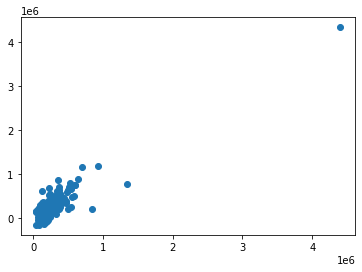

In [20]:
plt.scatter(y_test, lr.predict(x_test))


In [29]:
px.scatter(x=lr.predict(x_test))


In [ ]:
px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
